In [37]:
import queries
import requests
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import time

In [2]:
nasdaq_ids = queries.get_all_nasdaq_ids()

In [56]:
session = requests.Session()
#trades = queries.get_historical_trades(session=session, nasdaq_id=nasdaq_ids[11][0], from_date="2021-05-01", to_date="2021-05-01")
trades = []
start_date = dt.date(2021, 6, 1)
from_date = start_date
today = dt.date.today()
while from_date < today:
    to_date = from_date + dt.timedelta(10)
    
    to_date_str = to_date.strftime("%Y-%m-%d")
    from_date_str = from_date.strftime("%Y-%m-%d")
    
    new_trade_data = queries.get_historical_trades(session=session, nasdaq_id="CSE1586", 
                                                   from_date=from_date_str, to_date=to_date_str)
    trades.append(new_trade_data)
    from_date = to_date + dt.timedelta(1)

Fetching id: CSE1586, from 2021-06-01, to 2021-06-11
Fetching id: CSE1586, from 2021-06-12, to 2021-06-22
Fetching id: CSE1586, from 2021-06-23, to 2021-07-03
Fetching id: CSE1586, from 2021-07-04, to 2021-07-14
Fetching id: CSE1586, from 2021-07-15, to 2021-07-25
Fetching id: CSE1586, from 2021-07-26, to 2021-08-05
Fetching id: CSE1586, from 2021-08-06, to 2021-08-16
Fetching id: CSE1586, from 2021-08-17, to 2021-08-27
Fetching id: CSE1586, from 2021-08-28, to 2021-09-07
Fetching id: CSE1586, from 2021-09-08, to 2021-09-18
Fetching id: CSE1586, from 2021-09-19, to 2021-09-29
Fetching id: CSE1586, from 2021-09-30, to 2021-10-10
Fetching id: CSE1586, from 2021-10-11, to 2021-10-21
Fetching id: CSE1586, from 2021-10-22, to 2021-11-01
Fetching id: CSE1586, from 2021-11-02, to 2021-11-12
Fetching id: CSE1586, from 2021-11-13, to 2021-11-23
Fetching id: CSE1586, from 2021-11-24, to 2021-12-04
Fetching id: CSE1586, from 2021-12-05, to 2021-12-15
Fetching id: CSE1586, from 2021-12-16, to 2021

In [161]:
df = pd.concat(trades).reset_index(drop=True)
df['Trade_time'] = df['Trade_time'].dt.tz_convert('Europe/Copenhagen')
df = df.iloc[4000*15:]

In [66]:
df_clean = queries.remove_outliers(df)

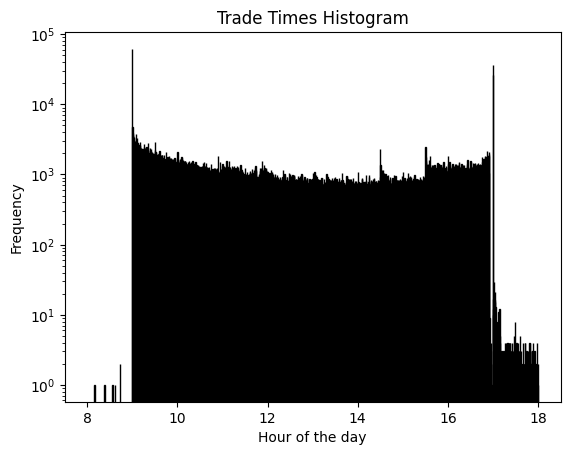

In [162]:
# Convert time to minutes since midnight
df['Minutes_since_midnight'] = (df['Trade_time'].dt.hour * 60 + df['Trade_time'].dt.minute + df['Trade_time'].dt.second / 60.0)/60

# Plotting
plt.hist(df['Minutes_since_midnight'], bins=2000, edgecolor="k", range=(8, 18))  # 48 bins for half-hour intervals
plt.xlabel("Hour of the day")
plt.ylabel("Frequency")
plt.title("Trade Times Histogram")
plt.yscale('log')
plt.show()

In [211]:
# Extract the time component from Trade_time for easy comparison
df['Time_only'] = df['Trade_time'].dt.time

# Create masks for the opening and closing auctions
opening_mask = (df['Time_only'] >= pd.Timestamp('08:59:00').time()) & (df['Time_only'] <= pd.Timestamp('09:00:03').time())
closing_mask = (df['Time_only'] >= pd.Timestamp('16:56:00').time()) & (df['Time_only'] <= pd.Timestamp('17:05:00').time())

# Group by Trade_date and Price, then sum the Volume
grouped_opening = df[opening_mask].groupby(['Trade_date', 'Price'])['Volume'].sum()
grouped_closing = df[closing_mask].groupby(['Trade_date', 'Price'])['Volume'].sum()

# Find the price level with the maximum volume for each Trade_date
opening_volumes = grouped_opening.groupby('Trade_date').idxmax().apply(lambda x: grouped_opening[x])
closing_volumes = grouped_closing.groupby('Trade_date').idxmax().apply(lambda x: grouped_closing[x])

In [187]:
df[df['Trade_date'] == dt.date(2023, 10, 27)]

,Price,Volume,Trade_time,Trade_date,Minutes_since_midnight,Time_only
1959881,158.55,30,2023-10-27 09:00:01.820000+02:00,2023-10-27,9.000278,09:00:01.820000
1959882,158.55,4,2023-10-27 09:00:01.820000+02:00,2023-10-27,9.000278,09:00:01.820000
1959883,158.55,26,2023-10-27 09:00:01.820000+02:00,2023-10-27,9.000278,09:00:01.820000
1959884,158.55,601,2023-10-27 09:00:01.820000+02:00,2023-10-27,9.000278,09:00:01.820000
1959885,158.55,194,2023-10-27 09:00:01.820000+02:00,2023-10-27,9.000278,09:00:01.820000
...,...,...,...,...,...,...
1970115,161.85,304,2023-10-27 16:59:45.270000+02:00,2023-10-27,16.995833,16:59:45.270000
1970116,161.85,2619,2023-10-27 16:59:45.270000+02:00,2023-10-27,16.995833,16:59:45.270000
1970117,162.70,300,2023-10-27 17:01:50+02:00,2023-10-27,17.030556,17:01:50
1970118,161.00,250,2023-10-27 18:24:58+02:00,2023-10-27,18.416111,18:24:58


In [213]:
# Create masks for the opening and closing auctions
opening_mask = (df['Time_only'] >= pd.Timestamp('08:58:00').time()) & (df['Time_only'] <= pd.Timestamp('09:00:15').time())
closing_mask = (df['Time_only'] >= pd.Timestamp('16:56:00').time()) & (df['Time_only'] <= pd.Timestamp('17:10:00').time())

# Group by Trade_date and Price, then count the trades
grouped_opening_count = df[opening_mask].groupby(['Trade_date', 'Price']).size()
grouped_closing_count = df[closing_mask].groupby(['Trade_date', 'Price']).size()

# Find the price level with the most trades
opening_max_trades_price = grouped_opening_count.groupby('Trade_date').sum()
closing_max_trades_price = grouped_closing_count.groupby('Trade_date').sum()

# For that price level, get the total volume
opening_volumes = df[opening_mask].groupby(['Trade_date', 'Price'])['Volume'].sum().loc[opening_max_trades_price].reset_index(level=1)
closing_volumes = df[closing_mask].groupby(['Trade_date', 'Price'])['Volume'].sum().loc[closing_max_trades_price].reset_index(level=1)


KeyError: '[108  66 111 166 151 137 147 132 176  79 158 258 105 144 105  81 108  78\n 201 151 168 115 131 288 115 118  68  97 151 127  89 100 232 201 106 122\n  79 140  88 123 248 204 173 149 116 182 116 147 448 176 169 139 191 103\n 142 238 112 251 159 305 119 129 243 314 170 139 143 156 156  94  93 189\n 165 113  87 122 181 149 159  88 100 183 209 187 159 116 117 159 129 119\n  96 336 233 173 162 129 132 142 124 115  93 122 180 110 112 104 131 175\n 129 136  66 180 217 252 119 123 152 100 210 123  89  74 113  82 110 108\n  85 205 121  95  85 185  84  93  95 171 178 166 193 114 164 125 209 183\n 266 344 164 151 154 173 165 169 126 186 137 235 160 152 460 206 153 134\n 221 162 128 282  78 117  74 105 149 284 104 313 153 236 203 223 103 304\n 495 178 220 122 124 164 117 112 108  95 126 202 100  87  77  98  86  99\n 100 164 123 147  76   5 119 124  79   5 141 101  70  11  73   5  94 144\n 198 103  90 114 102 115 113  80 129  78  74 100  73   1   6  60 254 102\n  65  96  82 201 106  54  70 126 120  82  69  79 107  60  63 109 123   8\n 131 106 105 121 109 290 148  93  89  67  87  76  98  81 107 119  96  68\n  55 129 132  99  75  74  92  79  70  95  75  93  66 111  56  78 111 181\n  78  83  77 143  82 112 117 133  79  79  99 100 113  96 126  67  82  96\n 102  89  89  73 121  59 110  84 111 158 128  95  78  99 109 109  94  82\n 123 103 101  87  63  52  76  78  85  61 270 430 182 144 101 209 123  98\n  95 118 163  92  98 119  76 125  93  93 114  78 116  90 203 119 166  78\n  70 101  65 120  75 241 125 151 103 103 101 177 100 133  81  82  83 119\n 168 153 174 147 147  95 141 134 124  75 187 141 106  86  90  83 190  90\n 125 335 170 244  87 132 128 172 161  88  87 111 142 190 112 195  86  79\n 114 132 135 101  98 134  76  57  73  83 125  89 100  82  71  94  87  99\n 102  92 202 119  98  81  75 107  74  87  86 139  96  98  86 151  77 135\n  56  92  69 119 120 129 116  84  82 103 102  92 110  90 114 156  87 120\n  84 113  78  76 123 234] not in index'

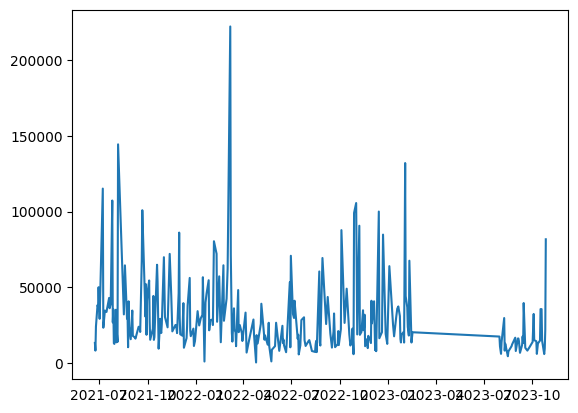

In [212]:
plt.plot(opening_volumes)

In [73]:
import math

def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

convert_size(df_clean.memory_usage(deep=True).sum())

'120.25 MB'

In [27]:
i = 80
start_date + dt.timedelta(10*i)

datetime.date(2023, 8, 10)

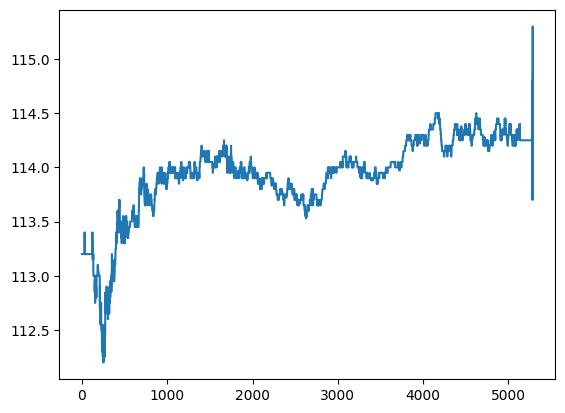

In [15]:
plt.plot(trades['Price'])

In [208]:
plt.plot(trades_df['Price'])

NameError: name 'trades_df' is not defined

In [296]:
print(f"Outliers removed: {len(trades_df)-len(filtered_df)}")

Outliers removed: 0
